In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from nnfabrik.builder import get_data, get_model, get_trainer

from neuralpredictors.training import (
    LongCycler,
    MultipleObjectiveTracker,
    early_stopping,
)

# loading the SENSORIUM dataset
filenames = ['data/static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', ]

dataset_fn = 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':0.25,
                 }

dataloaders = get_data(dataset_fn, dataset_config)

In [2]:
import os 

path = 'data/static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data/responses'
n_files = len(os.listdir(path))
responses = []
for i in range(n_files):
    res = np.load(path+f'/{i}.npy')
    responses.append(np.expand_dims(res, axis=0))

In [3]:
responses = np.concatenate(responses, axis=0)

In [4]:
responses.shape

(6955, 7776)

In [5]:
import torch
import torch.nn as nn
import torch.distributions as D
import torch.optim as optim
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from scipy.stats import gamma as gamma_dist

class Gamma(nn.Module):
    def __init__(self):
        super(Gamma, self).__init__()
        # Ensure parameters are positive using softplus
        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.beta = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        alpha = torch.nn.functional.softplus(self.alpha)
        beta = torch.nn.functional.softplus(self.beta)
        dist = D.Gamma(concentration=alpha, rate=beta)
        return dist.log_prob(x), alpha.item(), beta.item()

def fit_gamma_distribution(neuron_data, lr=0.05, steps=500, min_threshold=1e-5):
    """
    Fits a Gamma distribution to a single neuron's time series.
    
    Args:
        neuron_data (array): 1D array of responses over time.
        lr (float): Learning rate.
        steps (int): Number of optimization steps.
        min_threshold (float): Values below this are excluded from the fit.

    Returns:
        (alpha, beta): Parameters of the Gamma distribution.
    """
    # Filter out NaNs and near-zero values
    x = torch.tensor(neuron_data, dtype=torch.float32)
    x = x[(x > min_threshold) & ~torch.isnan(x)]
    
    if len(x) < 10:  # not enough valid data
        return np.nan, np.nan

    model = Gamma()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for _ in range(steps):
        optimizer.zero_grad()
        log_probs, _, _ = model(x)
        loss = -log_probs.mean()
        loss.backward()
        optimizer.step()

    _, alpha, beta = model(x)
    return alpha, beta

def plot_gamma_fit(neuron_data, alpha, beta, min_threshold=1e-3, bins=100, xlim=None):
    """
    Plot the histogram of the data and the fitted Gamma distribution PDF.
    
    Args:
        neuron_data: 1D array of time series data.
        alpha, beta: Gamma distribution parameters.
        min_threshold: Drop values below this.
        bins: Histogram bins.
        xlim: Tuple (xmin, xmax) to define x-axis range.
    """
    # Filter data
    data = neuron_data[(neuron_data > min_threshold) & ~np.isnan(neuron_data)]
    if len(data) == 0:
        print("No data above threshold.")
        return

    # Set x range
    if xlim is None:
        xmin, xmax = np.min(data), np.max(data)
    else:
        xmin, xmax = xlim

    # Histogram
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=bins, density=True, alpha=0.6, label="Data", range=(xmin, xmax))

    # Gamma PDF
    x = np.linspace(xmin, xmax, 300)
    pdf = gamma_dist.pdf(x, a=alpha, scale=1/beta)  # scale = 1 / rate

    plt.plot(x, pdf, 'r-', lw=2, label=f'Gamma PDF\nα={alpha:.2f}, β={beta:.2f}')
    plt.xlabel("Response Value")
    plt.ylabel("Density")
    plt.title("Gamma Fit to Neuron Response")
    plt.legend()
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()
    
from scipy.stats import gamma as gamma_dist
import numpy as np

def resample_to_target_gamma(neuron_data, a1, b1, a2, b2, min_threshold=1e-5):
    """
    Resample neural data from Gamma(a1, b1) to Gamma(a2, b2).
    
    Args:
        neuron_data (np.array): 1D array of neural responses.
        a1, b1 (float): Original Gamma parameters (shape, rate).
        a2, b2 (float): Target Gamma parameters (shape, rate).
        min_threshold (float): Ignore values below this threshold.
    
    Returns:
        time_ids (np.array): Indices of the retained time steps.
        resampled_data (np.array): Neural responses resampled to match Gamma(a2, b2).
    """
    # Keep only valid values
    valid_mask = (neuron_data > min_threshold) & ~np.isnan(neuron_data)
    data = neuron_data[valid_mask]
    time_ids = np.where(valid_mask)[0]
    
    if len(data) == 0:
        raise ValueError("No valid data points after thresholding.")
    
    # Convert to uniform using original Gamma CDF
    uniform_vals = gamma_dist.cdf(data, a=a1, scale=1/b1)

    # Inverse CDF (PPF) of target Gamma
    resampled_data = gamma_dist.ppf(uniform_vals, a=a2, scale=1/b2)

    return time_ids, resampled_data

In [6]:
gamma_fits = []

for i in tqdm(range(100)):  # for all 7776 neurons
    ts = responses[:, i]
    alpha, beta = fit_gamma_distribution(ts)
    gamma_fits.append((alpha, beta))

gamma_fits = np.array(gamma_fits)

100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


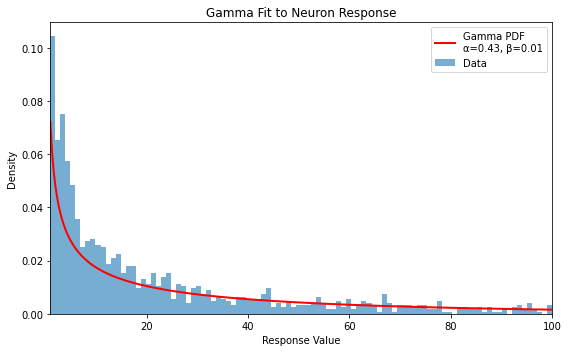

In [50]:
neuron_index = 50
alpha, beta = gamma_fits[neuron_index]
neuron_ts = responses[:, neuron_index]
plot_gamma_fit(neuron_ts, alpha, beta, xlim=(1,100))

In [51]:
neuron_index = 50
neuron_ts = responses[:, neuron_index]

# Original and target gamma parameters
a1, b1 = gamma_fits[neuron_index]
a2, b2 = gamma_fits[21]  # Example target gamma

# Resample
time_ids, resampled_ts = resample_to_target_gamma(neuron_ts, a1, b1, a2, b2)

[ 3.5740235 10.9430275  6.9898076 ...  0.3404593 37.871033  32.167908 ]
[   1    3    4 ... 6951 6952 6954]
[ 6.07397268 15.28857501 10.53595387 ...  0.91196556 43.94755732
 38.15731345]


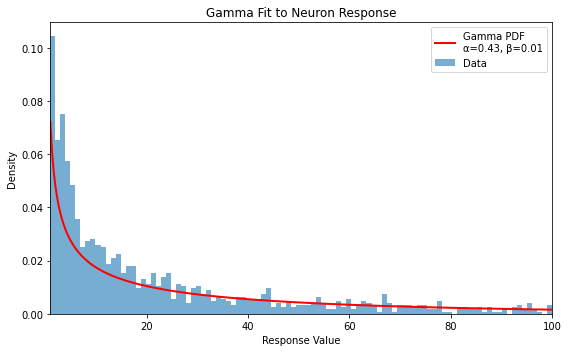

In [59]:
print(neuron_ts[neuron_ts>1e-5])
print(time_ids)
print(resampled_ts)

plot_gamma_fit(neuron_ts, a1, b1, xlim=(1,100))

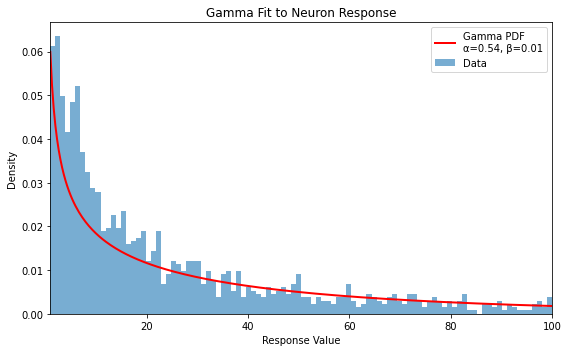

In [60]:
plot_gamma_fit(resampled_ts, a2, b2, xlim=(1,100))

In [ ]:
from scipy.stats import gamma as gamma_dist
import numpy as np

def resample_to_target_gamma(neuron_data, a1, b1, a2, b2, min_threshold=1e-3):
    """
    Resample neural data from Gamma(a1, b1) to Gamma(a2, b2).
    
    Args:
        neuron_data (np.array): 1D array of neural responses.
        a1, b1 (float): Original Gamma parameters (shape, rate).
        a2, b2 (float): Target Gamma parameters (shape, rate).
        min_threshold (float): Ignore values below this threshold.
    
    Returns:
        time_ids (np.array): Indices of the retained time steps.
        resampled_data (np.array): Neural responses resampled to match Gamma(a2, b2).
    """
    # Keep only valid values
    valid_mask = (neuron_data > min_threshold) & ~np.isnan(neuron_data)
    data = neuron_data[valid_mask]
    time_ids = np.where(valid_mask)[0]
    
    if len(data) == 0:
        raise ValueError("No valid data points after thresholding.")
    
    # Convert to uniform using original Gamma CDF
    uniform_vals = gamma_dist.cdf(data, a=a1, scale=1/b1)

    # Inverse CDF (PPF) of target Gamma
    resampled_data = gamma_dist.ppf(uniform_vals, a=a2, scale=1/b2)

    return time_ids, resampled_data

Median and Mean over data in figure range for neuron 21: 13.880962 23.52102 25.04233 [0.54283917 0.01424656]
Median and Mean over data in figure range for neuron 52: 11.577854 19.52822 20.664019 [0.49610037 0.01813252]


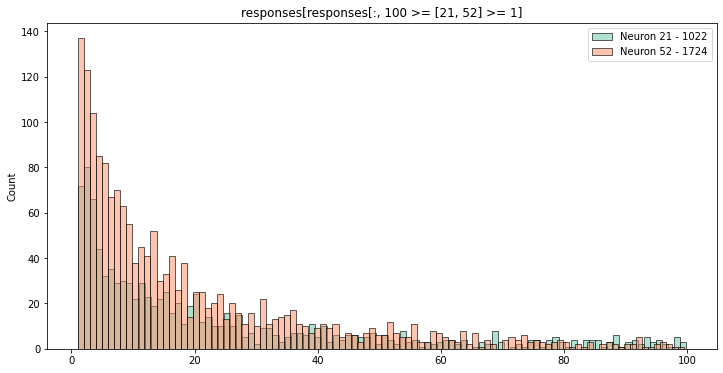

In [17]:
import seaborn as sns

ub, lb = (100, 1)
neuron_id_list = [21, 52]  
# neuron_id_list = [21, 69, 91, 90, 52, 64, 72, 56, 49, 50, 44,  8, 10,  3, 88, 33, 47]
#        16, 82, 73, 70,  0,  4, 32, 89, 40, 77, 42,  7, 30, 20, 14, 96, 68,
#        78, 79, 55, 94, 58, 34, 35, 22, 98, 12, 75, 13, 54, 39, 80, 87, 24,
#        31, 86, 92, 60, 11, 57, 62, 95, 36,  1, 74, 38, 41, 99, 59, 61,  2,
#        65, 23, 97, 53,  6, 17, 29, 46, 76, 15, 83,  9, 71, 19, 67, 81, 48,
#        85,  5, 93, 26, 43, 63, 27, 66, 45, 28, 25, 37, 18, 84, 51]   # by corr

# Use a Seaborn color palette
palette = sns.color_palette("Set2", n_colors=len(neuron_id_list))

plt.figure(figsize=(12, 6))
for i, neuron_id in enumerate(neuron_id_list):
    filtered_data = responses[(ub >= responses[:, neuron_id]) & (responses[:, neuron_id] >= lb), neuron_id]
#     print(f"Median and Mean over all data for neuron {neuron_id}:", np.median(responses[:, neuron_id]), np.mean(responses[:, neuron_id]))
    print(f"Median and Mean over data in figure range for neuron {neuron_id}:", np.median(filtered_data), np.mean(filtered_data), np.std(filtered_data), gamma_fits[neuron_id])
#     sns.axvline(x = np.mean(responses[:, neuron_id], color = palette[i])
    sns.histplot(filtered_data, bins=100, label=f'Neuron {neuron_id} - {len(filtered_data)}', alpha=0.5, color=palette[i])

plt.title(f'responses[responses[:, {ub} >= {neuron_id_list} >= {lb}]')
plt.legend()
plt.show()
plt.show()

In [64]:
(ub >= responses[:, neuron_id]) & (responses[:, neuron_id] >= lb)

array([False, False, False, ..., False,  True, False])

In [24]:
ub >= responses[:, neuron_id]

array([ True,  True,  True, ...,  True,  True,  True])

In [82]:
np.log(responses[:, 21])

array([-16.503746  , -15.619617  , -17.686039  , ..., -16.690353  ,
        -0.28295246, -15.634479  ], dtype=float32)

In [90]:
arr = np.log(responses[responses[:, 21]>0, 21])

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,
          2.,   2.,   3.,  10.,   7.,  16.,  23.,  31.,  76., 107., 164.,
        236., 309., 368., 386., 372., 321., 287., 226., 161., 144., 113.,
         65.,  61.,  33.,  21.,  21.,  12.,   5.,   4.,   5.,   3.,   3.,
          0.,   0.,   1.,   2.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   2.,   2.,   4.,   3.,   6.,   8.,   5.,  11.,  15.,
          9.,  24.,  32.,  32.,  30.,  44.,  71.,  60.,  58.,  63.,  80.,
         89.,  95.,  95.,  65.,  78.,  59.,  61.,  73.,  62.,  53.,  43.,
         11.]),
 array([-2.3778784e+01, -2.3481422e+01, -2.3184059e+01, -2.2886698e+01,
        -2.2589334e+01, -2.2291973e+01, -2.1994612e+01, -2.1697248e+01,
        -2.1399887e+01, -2.1102526e+01, -2.0805162e+01, -2.0507801e+01,
        -2.0210438e+01, -1.9913076e+01, -1.9615715e+01, -1.9318352e+01,
        -1.9020990e+01, -1.872

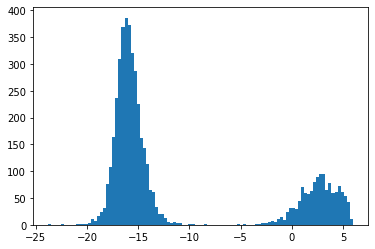

In [92]:
plt.hist(arr, bins=100)

array([0.54283917, 0.01424656])

In [13]:
arr = [37, 51, 45, 75, 66, 27, 60, 63, 83, 43, 18, 74, 15, 35, 57, 28, 84,
       85, 19, 99, 12, 38, 77, 31, 71, 25, 39, 13, 95,  1, 34, 36, 76, 26,
       96, 79, 93, 73, 64, 97, 92, 46, 48,  2, 23,  6, 17, 33, 68, 94, 98,
       16, 86, 53, 69, 32, 65, 42,  0, 88, 81, 54, 14, 61, 40, 50, 89, 67,
       78, 29, 82,  3, 90, 52, 70, 56, 22, 87, 80,  4, 11, 55, 62, 58, 20,
       10, 24,  8, 41, 47, 49, 72,  7, 21, 91, 44,  5, 30,  9, 59]

In [14]:
kur_arr = []

for neuron_id in arr:
    alpha, beta = gamma_fits[neuron_id]
    kur_arr.append(6/alpha)

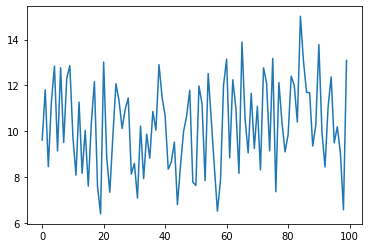

In [15]:
plt.plot(kur_arr)